# From trained model to HW using the finn compiler

We will go through network preparation (mainly through [Strealining](https://arxiv.org/pdf/1709.04060) graph transformations) and conversion to HW using the finn compiler.

In [5]:
root_dir = "/tmp/finn_dev_rootmin"
# get onnx model from last LAB
filename = root_dir + "/ready_finn.onnx"

In [6]:
from finn.util.visualization import showSrc, showInNetron
showInNetron(filename)

# Network preparing for finn

## Steps summary

- Tidy up (and also after EACH step)
- Pre (data feed) / Post proc (top k)
- **Model streamlining (Main step)** + smaller example
- Model HW Layers (Generates Matrix Vector Activation Units for fc layers)
- Model data flow partitions (Generate a sub-graph for all HW convertible nodes)
- Specialize layer, ready for hw conversion (generates hls for the dataflow partition node)

We then adapt the compiler setting dempending on the ressources requirements and call FINN API to generate a stitched IP.

## Tidy up

The goal of these transformation are simply to give node names & identifiers.

In [7]:
from qonnx.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs
from qonnx.transformation.infer_shapes import InferShapes
from qonnx.transformation.infer_datatypes import InferDataTypes
from qonnx.transformation.fold_constants import FoldConstants
from qonnx.core.modelwrapper import ModelWrapper

model = ModelWrapper(filename)

# TIDY UP
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())
model = model.transform(RemoveStaticGraphInputs())

model.save(root_dir + "/tidy.onnx")

In [8]:
showInNetron(root_dir + "/tidy.onnx")

### Pre processing

FINN model will only use 0 to 255 INT8 input once in hgardware, [or at least it will assume integer input](https://github.com/Xilinx/finn/issues/1174#issuecomment-2331778330)

We will feed UINT8 quantized values into the model, ranging from 0 to 255, because we did so in training. If the model was trained on FP32 ranging from 0 to 1, adding preprocessing into the graph, like in the commented example below, would be the right solution.

We also grab the opportunity to infer the input data type for the FINN compiler to adapt the input interface processing.

In [9]:
from finn.util.pytorch import ToTensor
from qonnx.transformation.merge_onnx_models import MergeONNXModels
from qonnx.core.datatype import DataType
from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup
import torch
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN

# PRE PROC : NONE
model = ModelWrapper(root_dir + "/tidy.onnx")

"""
global_inp_name = model.graph.input[0].name
ishape = model.get_tensor_shape(global_inp_name)
# preprocessing: torchvision's ToTensor divides uint8 inputs by 255
totensor_pyt = ToTensor()
export_qonnx(totensor_pyt, torch.randn(ishape), root_dir + "/preproc.onnx")
qonnx_cleanup(root_dir + "/preproc.onnx", out_file=root_dir + "/preproc.onnx")
pre_model = ModelWrapper(root_dir + "/preproc.onnx")
pre_model = pre_model.transform(ConvertQONNXtoFINN())

# join preprocessing and core model
model = model.transform(MergeONNXModels(pre_model))
"""

# add input quantization annotation: UINT8
global_inp_name = model.graph.input[0].name
model.set_tensor_datatype(global_inp_name, DataType["UINT8"])


model.save(root_dir + "/full_preproc.onnx")
showInNetron(root_dir + "/full_preproc.onnx")

## TEST THE NEW MODEL

Now, we can test this new model in order to check wether we did a good job so far with the different datatypes.

In [10]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

model = ModelWrapper(root_dir + "/full_preproc.onnx")

# get some INT 8 data by quantizing some FashionMNIST data
def quantize_tensor(x, num_bits=8):
    qmin = 0.
    qmax = 2.**num_bits - 1.
    min_val, max_val = x.min(), x.max()

    scale = (max_val - min_val) / (qmax - qmin)
    initial_zero_point = qmin - min_val / scale

    zero_point = 0
    if initial_zero_point < qmin:
        zero_point = qmin
    elif initial_zero_point > qmax:
        zero_point = qmax
    else:
        zero_point = initial_zero_point

    zero_point = int(zero_point)
    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    
    return q_x

# Define the quantized transform
transform_quantized = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Lambda(lambda x: quantize_tensor(x))  # Apply quantization
])

# Load the test dataset
test_dataset_qnt = datasets.FashionMNIST(
    root='./data',
    train=False,  # Load the test set
    download=True,
    transform=transform_quantized
);

# Check how it looks (looks good, nice)
print("Quick check on data...")
print(torch.min(test_dataset_qnt[0][0]))
print(torch.max(test_dataset_qnt[0][0]))
print(test_dataset_qnt[0][0].dtype)

test_loader_qnt = DataLoader(test_dataset_qnt, 100)

# RUN INFERENCE
from qonnx.core.modelwrapper import ModelWrapper
import qonnx.core.onnx_exec as oxe

# test the model
correct = 0
total = 0
loss_total = 0
print("\\nRunning the testing loop with ONNX model inference !\n")

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader_qnt):
        images = torch.reshape(images, (100, 28*28))
        for image_idx, image in enumerate(images):
            input_tensor = image.detach().numpy().reshape(1, 28 * 28)
            # print(input_tensor)
            input_dict = {"global_in": input_tensor}
            output_dict = oxe.execute_onnx(model, input_dict)
            produced_qonnx = output_dict[list(output_dict.keys())[0]]
            _, predicted = torch.max(torch.from_numpy(produced_qonnx).data, 1)
            total += 1
            correct += predicted.item() == labels[image_idx].item()
            if image_idx % 10 == 0 :
                print(image_idx, "done ! Accuracy so far : ", 100 * correct / total)
        if batch_idx == 0 : break # just do 1 batch, too long !

    accuracy = 100 * correct / total
    print("accuracy =", accuracy, "%")

We also apply post processing ! In our case we add a "tok K" label selector that will directly output the class value with the most credence. We grab the opportunity to do a tidy up again, as we added nodes in the graph that were not there in the fity tidy up graph transformations.

In [11]:
from qonnx.transformation.insert_topk import InsertTopK

# POST PROC

# insert Top-1 node at the end
model = model.transform(InsertTopK(k=1))
chkpt_name = root_dir + "/pre_post.onnx"
# tidy-up again
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())
model = model.transform(RemoveStaticGraphInputs())
model.save(chkpt_name)

showInNetron(chkpt_name)

## Model [streamlining](https://arxiv.org/pdf/1709.04060)

This set of transformations are one of the main steps, it infer thesholds in the graph and moves operations around. The end goal is to have a full integers model for inference and a streamlined graph structure easily convertible in HW layers.

You can vizualize the set of transformation in [this paper](https://arxiv.org/pdf/1709.04060) or by using ```showSrc(Streamline)```

In [12]:
from finn.transformation.streamline import Streamline
# we can see the list of apllied transformations here : showSrc(Streamline)
from finn.transformation.streamline.reorder import MoveScalarLinearPastInvariants
import finn.transformation.streamline.absorb as absorb

model = ModelWrapper(root_dir + "/pre_post.onnx")
# STREAMLINE
model = model.transform(Streamline())
model.save(root_dir + "/streamlined.onnx")
showInNetron(root_dir + "/streamlined.onnx")

The following block is kind of "useless" but showcases examples of transformations made during the streamlining process

In [13]:
# MODEL PREP
# These transformations are similar in what we can find in the Streamline collection of transforms, but we show some here for demonstration...

from qonnx.transformation.bipolar_to_xnor import ConvertBipolarMatMulToXnorPopcount
from finn.transformation.streamline.round_thresholds import RoundAndClipThresholds
from qonnx.transformation.infer_data_layouts import InferDataLayouts
from qonnx.transformation.general import RemoveUnusedTensors

model = ModelWrapper(root_dir + "/streamlined.onnx")

model = model.transform(ConvertBipolarMatMulToXnorPopcount())
model = model.transform(absorb.AbsorbAddIntoMultiThreshold())
model = model.transform(absorb.AbsorbMulIntoMultiThreshold())
# absorb final add-mul nodes into TopK
model = model.transform(absorb.AbsorbScalarMulAddIntoTopK())
model = model.transform(RoundAndClipThresholds())

# bit of tidy-up
model = model.transform(InferDataLayouts())
model = model.transform(RemoveUnusedTensors())

model.save(root_dir + "/streamlined_merged_and_ready.onnx")
showInNetron(root_dir + "/streamlined_merged_and_ready.onnx")

## Re-test

To make sure everythong setup correctly, we can  re-test our ONNX Model's graph using the OXE runtime and comparing accuracies

In [14]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from qonnx.core.modelwrapper import ModelWrapper
import qonnx.core.onnx_exec as oxe

model = ModelWrapper(root_dir + "/streamlined_merged_and_ready.onnx")

# Note that data has already been imported in the first test

# Check how the data looks
print("Quick check on data...")
print(torch.min(test_dataset_qnt[0][0]))
print(torch.max(test_dataset_qnt[0][0]))
print(test_dataset_qnt[0][0].dtype)

# re-instanciate the test loader
test_loader_qnt = DataLoader(test_dataset_qnt, 100)

# test the model
correct = 0
total = 0
loss_total = 0
print("\\nRunning the testing loop with ONNX model inference !\n")

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader_qnt):
        images = torch.reshape(images, (100, 28*28))
        for image_idx, image in enumerate(images):
            input_tensor = image.detach().numpy().reshape(1, 28 * 28)
            # print(input_tensor)
            input_dict = {"global_in": input_tensor}
            output_dict = oxe.execute_onnx(model, input_dict)
            produced_qonnx = output_dict[list(output_dict.keys())[0]]
            # watch out ! we added a top K post processing layer, we have to take it into account and modify our test code
            predicted = produced_qonnx[0][0]
            total += 1
            correct += predicted.item() == labels[image_idx].item()
            if image_idx % 10 == 0 :
                print(image_idx, "done ! Accuracy so far : ", 100 * correct / total)
        if batch_idx == 0 : break # just do 1 batch, too long !

    accuracy = 100 * correct / total
    print("accuracy =", accuracy, "%")

We can see that our model is still classifying the input as expected after the streamlining process, great ! Now let's move on to HW conversion.

*Note : c++ HLS and HW verification will be done in the verification notebook.*

# Convert to HW

## Generate HW Layers : MVAU

This step does not generate HLS nor RTL code, but rather merges thresholds and matrix vector operations (or convolutions if you use conv nets) into Matrix Vector Activation Units (or Sliding Window Units), if possible,  that each represent a layer that FINN can easily work with. Note that an input preprocessing quantiazer will be implemented as a simple standalone Threasholding layer that will then nbe converted to Thresholding_hls layer.

In [15]:
import finn.transformation.fpgadataflow.convert_to_hw_layers as to_hw
from qonnx.core.modelwrapper import ModelWrapper

# TO HW LAYERS

model = ModelWrapper(root_dir + "/streamlined_merged_and_ready.onnx")
model = model.transform(to_hw.InferLabelSelectLayer())
model = model.transform(to_hw.InferChannelwiseLinearLayer())
model = model.transform(to_hw.InferQuantizedMatrixVectorActivation())
model = model.transform(to_hw.InferThresholdingLayer())
model.save(root_dir + "/hw.onnx")
showInNetron(root_dir + "/hw.onnx")

Once MVAU are infered, we can ask FINN to discriminate HW convertible layers into dataflow partitions. In our case, all our layers are compatible, but in some cases, some operation might have to be done on software, of you may have to re-work your graph.

In [16]:
from finn.transformation.fpgadataflow.create_dataflow_partition import CreateDataflowPartition

model = ModelWrapper(root_dir + "/hw.onnx")
parent_model = model.transform(CreateDataflowPartition())
parent_model.save(root_dir + "/df_part.onnx")
showInNetron(root_dir + "/df_part.onnx")

# We see that our entire model is now part of a child model in "StreamingDataflowPartition"

We select the child model to work on it (i.e. actual HLS/RTL conversion) using [getCustopOp](https://finn.readthedocs.io/en/latest/source_code/finn.custom_op.html)

In [17]:
from qonnx.custom_op.registry import getCustomOp
sdp_node = parent_model.get_nodes_by_op_type("StreamingDataflowPartition")[0]
sdp_node = getCustomOp(sdp_node)
dataflow_model_filename = sdp_node.get_nodeattr("model")
showInNetron(dataflow_model_filename)

## MVAU HLS Conversion

In this process, we simply runnn a FINN API call that will generate HLS Layers from the MVAU / SLWU. To adapt the resulting HLS code, we also chose an FPGA part from the supported pool. You can simply choose a part that "ressembles" your end target as this is not the end Synth target for Vitis HLS RTL conversion.

In [18]:
# print the names of the supported PYNQ boards
from finn.util.basic import pynq_part_map
print(pynq_part_map.keys())

# change this if you have a different PYNQ board, see list above
pynq_board = "Pynq-Z1"
fpga_part = pynq_part_map[pynq_board]
target_clk_ns = 20

In [19]:
from finn.transformation.fpgadataflow.specialize_layers import SpecializeLayers
model = ModelWrapper(dataflow_model_filename)

model = model.transform(SpecializeLayers(fpga_part))

showSrc(SpecializeLayers)

model.save(root_dir + "/to_hw_conv.onnx")
showInNetron(root_dir + "/to_hw_conv.onnx")

## FOLDING PARAMETER AND LOOP UNROLLING

When dealing with ressource requirements, tinkering these parameters is the ways to go in order to find a balance between throughput and ressource utilization. Here are some examples from the [finn paper, table 3 on page 8](https://arxiv.org/pdf/1612.07119) on BNNs and the effect of maximize and minimizing the usage :

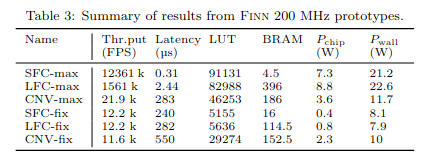

regarding the effects

> The higher the PE and SIMD values are set, the faster the generated accelerator will run, and the more FPGA resources it will consume. 

See [finn paper, figure 5 on page 5](https://arxiv.org/pdf/1612.07119) or refer to the lectures for better understanding of PE, SIMD, LOOP UNROLLING & FOLDING

### Gather information on current params

In [20]:
model = ModelWrapper(root_dir + "/to_hw_conv.onnx")

fc0 = model.graph.node[0] #1st MVAU
fc0w = getCustomOp(fc0)

print("CustomOp wrapper is of class " + fc0w.__class__.__name__)

fc0w.get_nodeattr_types()

### Set the folding

See manual example in this [finn notebook](https://github.com/Xilinx/finn/blob/main/notebooks/end2end_example/bnn-pynq/tfc_end2end_example.ipynb).

SetFolding will automatically try to figure out PE ans SIMD parameter depending on target requirements.

In [21]:
from finn.transformation.fpgadataflow.set_folding import SetFolding

TARGET_FPS = 10000
target_clk_cycles_per_frame = 1/(TARGET_FPS * 10e-9)

model = ModelWrapper(root_dir + "/to_hw_conv.onnx")

model.transform(SetFolding(target_cycles_per_frame=target_clk_cycles_per_frame, mvau_wwidth_max=64, two_pass_relaxation=True))

model.save(root_dir + "/to_hw_folded.onnx")

Note that you can also use [this transformation](https://github.com/Xilinx/finn/blob/9d299689f2ec0895f208b8bfe3bcdcf6f450181a/src/finn/transformation/fpgadataflow/set_fifo_depths.py#L199) to modify ififo and ofifo depth if needed.

# ACTUAL HARDWARE BUILD

We first run some estimations based on the TARGET FPS constant defined earlier

In [22]:
# ESTIMATE
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
import os
import shutil

model_file = root_dir + "/to_hw_folded.onnx"

estimates_output_dir = "output_estimates_only"

#Delete previous run results if exist
if os.path.exists(estimates_output_dir):
    shutil.rmtree(estimates_output_dir)
    print("Previous run results deleted!")


cfg_estimates = build.DataflowBuildConfig(
    output_dir          = estimates_output_dir,
    mvau_wwidth_max     = 80,
    target_fps          = TARGET_FPS,
    synth_clk_period_ns = 10.0,
    fpga_part           = "xc7z020clg400-1",
    steps               = build_cfg.estimate_only_dataflow_steps,
    generate_outputs=[
        build_cfg.DataflowOutputType.ESTIMATE_REPORTS,
    ]
)

build.build_dataflow_cfg(model_file, cfg_estimates)

### Read the estimates reports

In these reports, we can see the estimates fits our target, and we can get an overview of hw many LUTs will be used

In [23]:
! cat {estimates_output_dir}/report/estimate_network_performance.json

In [24]:
import json
def read_json_dict(filename):
    with open(filename, "r") as f:
        ret = json.load(f)
    return ret

read_json_dict(estimates_output_dir + "/report/estimate_layer_cycles.json")

In [25]:
read_json_dict(estimates_output_dir + "/report/estimate_layer_resources.json")

In [26]:
# Actual hardware build, ZYNQ BUILD
from finn.transformation.fpgadataflow.make_zynq_proj import ZynqBuild

model = ModelWrapper(root_dir + "/to_hw_conv.onnx")
model = model.transform(ZynqBuild(platform = pynq_board, period_ns = target_clk_ns,partition_model_dir="./test",enable_debug=True))

In [22]:
model.save(root_dir + "/post_synth.onnx")

In [23]:
showInNetron(root_dir + "/post_synth.onnx")

In [24]:
model = ModelWrapper(root_dir + "/post_synth.onnx")

In [25]:
model.model.metadata_props
# en fouillant un peu, on voit le projete mère avec deuc couvhes IODMA
# et en ouvrant le stiched projet de la couche du milleu on retrouve notre modèle (voir ci-dessous)

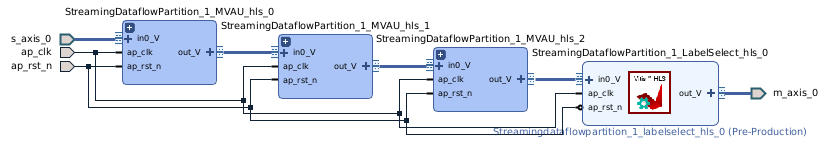

In [29]:
# On remarque également que notre modèle demande 8bits par 8bits
# ce qui veut dire qu'une image en tière se charge en 28*28*8/8 = 784 cycles
# avec 20ns par cycle = 15 680 ns / images soit 63 000 images /sec
# (en théorie.)

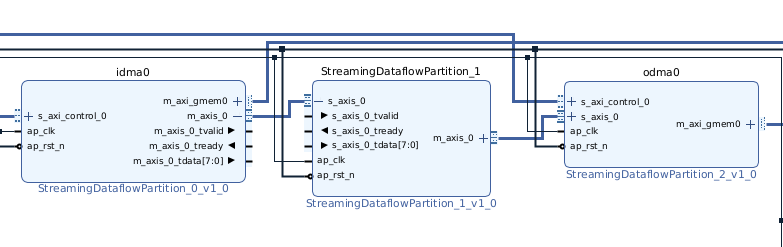  